# Copyright

<PRE>
Jelen iPython notebook a Budapesti Műszaki és Gazdaságtudományi Egyetemen tartott "Deep Learning a gyakorlatban Python és LUA alapon" tantárgy segédanyagaként készült. 

A tantárgy honlapja: http://smartlab.tmit.bme.hu/oktatas-deep-learning
Deep Learning kutatás: http://smartlab.tmit.bme.hu/deep-learning

A forráskódot GPLv3 licensz védi. Újrafelhasználás esetén lehetőség szerint kérejük az alábbi szerzőt értesíteni.

2016 (c) Tóth Bálint Pál (toth.b kukac tmit pont bme pont hu)
</PRE>

# Szinusz modellezése egy dimenziós konvolúcióval
Ebben a notebookban bemutatjuk, hogy hogyan lehet összerakni egy vektorból az egy dimenziós konvolúciós háló számmára szükséges (samples, steps, input_dim) bemenetet és ezt hogyan tudjuk összekötni előrecsatolt (fully connected) rétegekkel.

## Be- és kimenetek előkészítése
Töltsük be a megfelelő modulokat és készítsünk 0-10pi között 4000 ponttal sinus adatsort. A konvolúció háló bemenete sample_points számú, linspac ("X" tengely), a kimenete pedig a sample_points+1 helyen kévő sinus érték. Az egyes sample_point hosszú tanítóminták közötti eltolást a shift paraméterrel szabályozzuk. 

In [1]:
from keras.models import Sequential
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.layers.core import Dense, Dropout, Activation, Flatten

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

sample_points = 50 # az előadás fóliáin "m"-el jelöltük (FrameSize)
shift = 2 # az előadás fóliáin "s"-el jelöltük

lins = np.linspace(0,np.pi*10,4000)
data = np.asarray([np.sin(lins)]).T # egy sin és egy cos adatsor létrehozása
nb_samples = len(data) - sample_points - 1 # a minták száma, ha nem lenne "shift", azt majd három sorral lentebb vesszük figyelembe

# standardizálás
std_scaler = StandardScaler()
lins = std_scaler.fit_transform(lins)
# normalizálás
mm_scaler = MinMaxScaler(feature_range=(0, 1))
data = mm_scaler.fit_transform(data)

# bemenet létrehozása - a sin és cos sample_points pillanatban, shift lépésenként
# atleast_2d: legalább 2D-s mátrixokká alakítja a bemenetet, jelen esetben (50,2) alakú
# expand_dims: növeli a dimenzió számot a megadott axis mentén, így lesz jelen esetben (1,50,2) alakú mintánk, 
#              amiket majd egymás után fűzve hozzuk létre a tanítóadatokat
input_list = [np.expand_dims(np.atleast_2d(np.asarray([lins[i:i+sample_points]]).T), axis=0) for i in range(0,nb_samples,shift)]
X = np.concatenate(input_list, axis=0)
print("Bemenet alakja: ")
print(X.shape)

# az első öt bemeneti tanítóminta kiiratás
for i in range(0,5):
    print("\n"+str(i+1)+". bemeneti tanítóminta:")
    print(X[i])

Using Theano backend.


Bemenet alakja: 
(1975, 50, 1)

1. bemeneti tanítóminta:
[[-1.73161785]
 [-1.73075182]
 [-1.7298858 ]
 [-1.72901977]
 [-1.72815375]
 [-1.72728772]
 [-1.7264217 ]
 [-1.72555567]
 [-1.72468965]
 [-1.72382362]
 [-1.72295759]
 [-1.72209157]
 [-1.72122554]
 [-1.72035952]
 [-1.71949349]
 [-1.71862747]
 [-1.71776144]
 [-1.71689542]
 [-1.71602939]
 [-1.71516337]
 [-1.71429734]
 [-1.71343131]
 [-1.71256529]
 [-1.71169926]
 [-1.71083324]
 [-1.70996721]
 [-1.70910119]
 [-1.70823516]
 [-1.70736914]
 [-1.70650311]
 [-1.70563709]
 [-1.70477106]
 [-1.70390504]
 [-1.70303901]
 [-1.70217298]
 [-1.70130696]
 [-1.70044093]
 [-1.69957491]
 [-1.69870888]
 [-1.69784286]
 [-1.69697683]
 [-1.69611081]
 [-1.69524478]
 [-1.69437876]
 [-1.69351273]
 [-1.6926467 ]
 [-1.69178068]
 [-1.69091465]
 [-1.69004863]
 [-1.6891826 ]]

2. bemeneti tanítóminta:
[[-1.7298858 ]
 [-1.72901977]
 [-1.72815375]
 [-1.72728772]
 [-1.7264217 ]
 [-1.72555567]
 [-1.72468965]
 [-1.72382362]
 [-1.72295759]
 [-1.72209157]
 [-1.72122554]
 

/usr/local/lib/python3.4/dist-packages/sklearn/preprocessing/data.py:583: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/preprocessing/data.py:646: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [2]:
# kimenet létrehozása a fentiek szerint 
# mindig a következő időpillanatban jósolja előre a sin értékét
target_list = [np.atleast_2d(data[i+sample_points+1,0]) for i in range(0,nb_samples,shift)]
y = np.concatenate(target_list, axis=0)
print("\nKimenet alakja: ")
print(y.shape)

# az első öt kimeneti tanítóminta kiiratás
for i in range(0,5):
    print("\n"+str(i+1)+". kimeneti tanítóminta:")
    print(y[i])


Kimenet alakja: 
(1975, 1)

1. kimeneti tanítóminta:
[ 0.69500998]

2. kimeneti tanítóminta:
[ 0.70221941]

3. kimeneti tanítóminta:
[ 0.70937893]

4. kimeneti tanítóminta:
[ 0.71648676]

5. kimeneti tanítóminta:
[ 0.72354115]


## Modell létrehozása
Ezután létrehozzuk a modellt Sequential objektumként és egymás utána pakolunk conv1d-conv1d-maxpool1d-conv1d-conv1d-maxpool1d rétegeket egyre növekvő konvolúciós szűrő számmal. Nyilván ez a háló most túl van méretezve erre a feladatra.
Figyeljük meg az utolsó konvolúciós réteget, ahol a szűrő hossza mindössze 1, aminek az a jelentősége, hogy az adott konvolúciós réteg neuronjait a mélység (depth) mentén köti össze és ezekben keres összefüggéseket. 

In [3]:
model = Sequential()
model.add(Convolution1D(input_shape=(X.shape[-2],X.shape[-1]), #input_dim=inputDim,
                        nb_filter=32,
                        filter_length=3,
                        border_mode='same',
                        subsample_length=1,
                        init='glorot_normal',
                        activation='relu')) 
model.add(Convolution1D(nb_filter=96,
                        filter_length=5,
                        border_mode='same',
                        subsample_length=2,
                        init='glorot_normal',
                        activation='relu')) 
model.add(MaxPooling1D(pool_length=2,stride=2))
model.add(Convolution1D(nb_filter=128,
                        filter_length=7,
                        border_mode='same',
                        subsample_length=2,
                        init='glorot_normal',
                        activation='relu'))
model.add(Convolution1D(nb_filter=128,
                        filter_length=1,
                        border_mode='same',
                        init='glorot_normal',
                        subsample_length=2,
                        activation='relu')) 
model.add(MaxPooling1D(pool_length=2, stride=2)) 

## Előrecsatolt réteg
A konvolúciós rétegek kimenetének összekötését az előrecsatolt réteggel a Flatten() réteg végzi, majd utána következhetnek az előrcsatolt rétegek. Itt akár több előrecsatolt réteg is jöhetne, ami összetettebb feladatoknál szükséges a nagyobb pontossághoz, pl: 

               model.add(Dense(512, activation='relu'))
               model.add(Dropout(0.5))
               
Azonban most nem szeretnénk, hogy esetleg az előrecsatolt rétegek oldják meg a modellezést, ezért csak 1 neuront teszünk a kimeneti rétegbe. 


In [4]:
model.add(Flatten())
model.add(Dense(1, activation='linear'))

Ezt követően lefordítjuk a modellet (négyzete hiba a költségfüggvényt + Adam optimizációt használunk) és betanítjuk, most 40 epochig. Fontos, hogy a fit függvény a minták keverését is elvégzi nekünk. Szintén fontos, hogy éles alkalmazásban validációs adatokon kellene visszamérni a hiba csökkenését, és végül különálló teszt halmazon tesztelni.

In [5]:
model.compile(loss='mse', optimizer='adam')
model.fit(X, y, nb_epoch=40, shuffle=True)

Epoch 1/40
1975/1975 [==============================] - 1s - loss: 0.1569     
Epoch 2/40
1975/1975 [==============================] - 1s - loss: 0.1223     
Epoch 3/40
1975/1975 [==============================] - 1s - loss: 0.1215     
Epoch 4/40
1975/1975 [==============================] - 1s - loss: 0.1036     
Epoch 5/40
1975/1975 [==============================] - 1s - loss: 0.0862     
Epoch 6/40
1975/1975 [==============================] - 1s - loss: 0.0765     
Epoch 7/40
1975/1975 [==============================] - 1s - loss: 0.0755     
Epoch 8/40
1975/1975 [==============================] - 1s - loss: 0.0658     
Epoch 9/40
1975/1975 [==============================] - 1s - loss: 0.0580     
Epoch 10/40
1975/1975 [==============================] - 1s - loss: 0.0439     
Epoch 11/40
1975/1975 [==============================] - 1s - loss: 0.0331     
Epoch 12/40
1975/1975 [==============================] - 1s - loss: 0.0246     
Epoch 13/40
1975/1975 [==========================

Miután kész a tanítás készítünk egy predikciót és ezt kirajzoljuk:

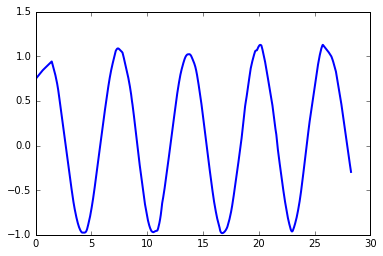

In [6]:
Y_predicted = model.predict(X, batch_size=100)
line, = plt.plot(std_scaler.inverse_transform(lins[0:3600:shift]), \
                 mm_scaler.inverse_transform(Y_predicted[0:int(3600/shift)]), \
                 '-', linewidth=2)